# TM10007 Assignment template

In [ ]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [ ]:
# Imports
# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn utilities
from sklearn import datasets as ds
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    RandomizedSearchCV,
    learning_curve
)

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

# Feature selection
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    mutual_info_classif,
    VarianceThreshold,
    RFECV,
    SelectFromModel
)
from sklearn.feature_selection import SequentialFeatureSelector

# Dimensionality reduction
from sklearn.decomposition import PCA

# Statistical testing
from scipy.stats import shapiro, randint

# Classifiers
from sklearn.linear_model import (
    LogisticRegression,
    SGDClassifier,
    Lasso,
    LassoCV
)
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis
)
from sklearn.svm import SVC

# Evaluation metrics
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    accuracy_score,
    f1_score
)

# Other utilities
import copy
from typing import List, Tuple, Union

# Custom module
from worclipo.load_data import load_data


In [ ]:
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

X = data.drop("label",axis=1)
y = data["label"]

#X_train, X_test, y_train, y_test = train_test_split(
    #X, y, test_size=0.2, random_state=42, stratify=y
#)

The number of samples: 115
The number of columns: 494
Fold 1:
 - Train size: 73
 - Validation size: 19
Fold 2:
 - Train size: 73
 - Validation size: 19
Fold 3:
 - Train size: 74
 - Validation size: 18
Fold 4:
 - Train size: 74
 - Validation size: 18
Fold 5:
 - Train size: 74
 - Validation size: 18


General functions to be used

In [103]:
# Some functions we will use
def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.

    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    else:
        Z = clf.predict_proba(features)
    if len(Z.shape) > 1:
        Z = Z[:, 1]

    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

def plot_roc_curve(y_score, y_truth):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, roc_auc

### Preprocessing

Missing data
* Part 1: Finding missing data

In [104]:
def find_missing_data(X_train):

    # Define missing value indicators
    custom_missing = ['NA', 'N/A', '?', 'None', 'none', '-']

    # Count NaNs
    nan_counts = X_train.isna().sum()

    # Count empty strings
    empty_string_counts = (X_train == '').sum()

    # Count custom missing indicators (case-insensitive match)
    custom_missing_counts = X_train.apply(lambda col: col.astype(str).str.lower().isin([val.lower() for val in custom_missing]).sum())

    # Compute total missing count per column
    total_missing = nan_counts + empty_string_counts + custom_missing_counts

    # Filter out columns where total missing is zero
    total_missing_selected = total_missing[total_missing != 0]

    # Print total missing counts
    print(total_missing_selected)

    return total_missing

#total_missing = find_missing_data(X_train)

Series([], dtype: int64)


* Part 2: Processing missing data

In [105]:
def process_missing_data(X_train, X_test, total_missing):

    # Replacing missing values with NaN
    custom_missing = ['NA', 'N/A', '?', 'None', 'none', '-', '']
    X_train.replace(custom_missing, np.nan, inplace=True)
    X_test.replace(custom_missing, np.nan, inplace=True)

    # If 50% or more of the data within one feature is missing the feature is deleted
    limit = len(X_train.index)*50/100
    valid_columns = [col for col, count in total_missing.items() if count < limit]

    # Keep only the valid columns in both X_train and X_test
    X_train = X_train[valid_columns]
    X_test = X_test[valid_columns]

    # Imputate

    # Check if imputation is needed
    if X_train.isna().sum().sum() == 0:
        pass
    else:
        # Dictionary to store mean/median decision per column
        imputation_strategies = {}

        for col in X_train.select_dtypes(include=['number']).columns:  # Only numeric columns
            col_data = X_train[col].dropna()  # Remove NaN values for testing

            if len(col_data) > 3:  # Shapiro requires at least 3 non-null values
                if col_data.nunique() == 1:  # Check if all values are the same
                    strategy = 'median'  # Default to median if no variability
                else:
                    _, p = shapiro(col_data)
                    strategy = 'mean' if p > 0.05 else 'median'
            else:
                strategy = 'median'  # Default to median if too few values

            imputation_strategies[col] = strategy

        # Create imputers for mean and median
        mean_imputer = SimpleImputer(strategy='mean')
        median_imputer = SimpleImputer(strategy='median')

        # Apply imputers for each feature
        for col, strategy in imputation_strategies.items():
            imputer = mean_imputer if strategy == 'mean' else median_imputer
            X_train[col] = imputer.fit_transform(X_train[[col]])
            X_test[col] = imputer.transform(X_test[[col]])  # Use the same imputer
    
    return X_train, X_test

#X_train, X_test = process_missing_data(X_train, X_test, total_missing)

Scaling data

In [106]:
def scaling(X_train, X_test):

    scaler_robust = preprocessing.RobustScaler()

    scaled_robust_array_train = scaler_robust.fit_transform(X_train)
    scaled_robust_array_test = scaler_robust.transform(X_test)

    X_scaled_robust_train = pd.DataFrame(scaled_robust_array_train, columns=X_train.columns)
    X_scaled_robust_test = pd.DataFrame(scaled_robust_array_test, columns=X_test.columns)

    return X_scaled_robust_train, X_scaled_robust_test

#X_scaled_robust_train, X_scaled_robust_test = scaling(X_train, X_test)

    PREDICT_original_sf_compactness_avg_2.5D  \
0                                   0.896064   
1                                   0.616268   
2                                   0.175550   
3                                   0.857793   
4                                  -0.455090   
5                                  -0.180561   
6                                  -0.886215   
7                                   0.984786   
8                                   0.203404   
9                                   0.968292   
10                                 -0.692793   
11                                  0.895339   
12                                  0.627915   
13                                  0.332836   
14                                 -0.503299   
15                                  0.245738   
16                                 -0.522331   
17                                  0.617171   
18                                  0.664795   
19                                  0.21

### Feature extraction

First step: variance based thresholding

In [107]:
def apply_variance_threshold(X_train, X_test, threshold=0.95):
    """
    Applies variance thresholding to remove low-variance features.

    Args:
        X_train (pd.DataFrame): Scaled training feature set.
        X_test (pd.DataFrame): Scaled test feature set.
        threshold (float): Threshold for variance. Features with variance below this will be removed.

    Returns:
        X_train_filtered (pd.DataFrame): Filtered training set.
        X_test_filtered (pd.DataFrame): Filtered test set.
        selected_features (List[str]): Names of the retained features.
    """
    selector_variance_threshold = VarianceThreshold(threshold=threshold)
    X_train_filtered_variance_np = selector_variance_threshold.fit_transform(X_train)
    selected_features = X_train.columns[selector_variance_threshold.get_support()]
    
    X_train_filtered = pd.DataFrame(X_train_filtered_variance_np, columns=selected_features, index=X_train.index)
    X_test_filtered = pd.DataFrame(selector_variance_threshold.transform(X_test), columns=selected_features, index=X_test.index)

    print(f"[VarianceThreshold] Remaining features: {len(selected_features)}")
    return X_train_filtered, X_test_filtered, selected_features

#X_filtered_train_variance_new, X_filtered_test_variance_new, variance_filtered_features_new = apply_variance_threshold(X_scaled_robust_train, X_scaled_robust_test)
#print(X_filtered_train_variance_new.shape)
#print(X_filtered_test_variance_new.shape)

[VarianceThreshold] Remaining features: 175
(92, 175)
(23, 175)


Filtering with ANOVA: linear relations

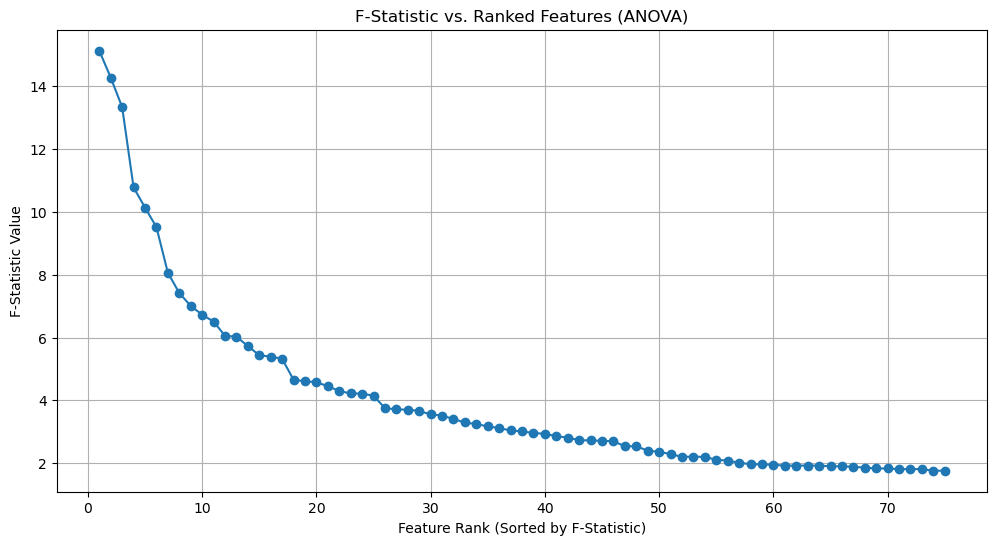

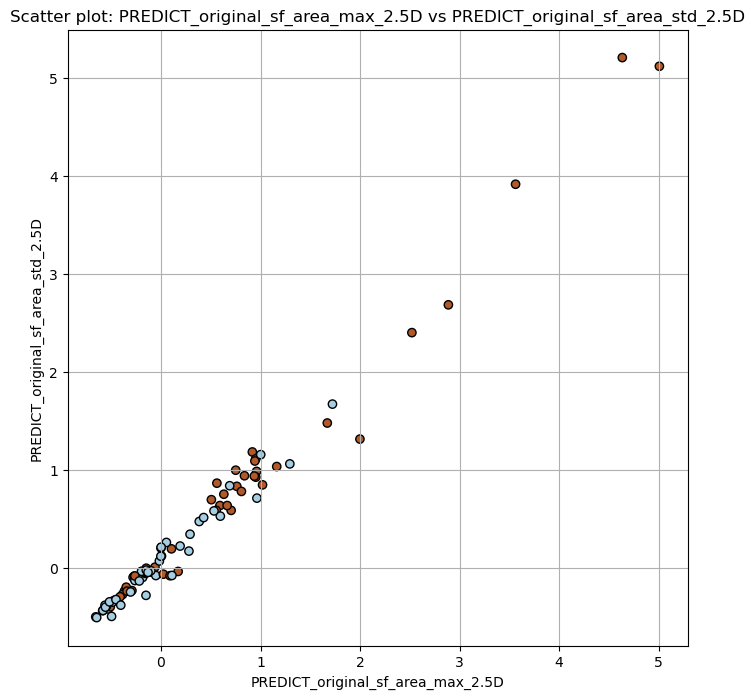

[ANOVA] Selected top-75 features.


In [108]:
def select_features_anova(X_train, y_train, X_test, k=75, plot=True):
    """
    Selects the top-k features using ANOVA F-test (for linear dependencies).

    Args:
        X_train (pd.DataFrame): Training features. 
        y_train (pd.Series or np.array): Training labels, numerically encoded
        X_test (pd.DataFrame): Test features.
        k (int): Number of top features to select.
        plot (bool): If True, visualizes F-statistics and top 2 feature scatter plot.

    Returns:
        X_train_anova (pd.DataFrame): Training set with selected features.
        X_test_anova (pd.DataFrame): Test set with selected features.
        selected_features (List[str]): Names of the selected features.
    """
    selector_anova = SelectKBest(f_classif, k=k)
    X_train_filtered_anova_np = selector_anova.fit_transform(X_train, y_train)
    selected_features = X_train.columns[selector_anova.get_support()]
    
    X_train_anova = pd.DataFrame(X_train_filtered_anova_np, columns=selected_features, index=X_train.index)
    X_test_anova = pd.DataFrame(selector_anova.transform(X_test), columns=selected_features, index=X_test.index)

    print(f"[ANOVA] Selected top-{k} features.")
    return X_train_anova, X_test_anova, selected_features

# Transform labels to numeric values, i.e. 0 or 1 
le = LabelEncoder()
y_train_numeric = le.fit_transform(y_train)
legend_labels = le.classes_  # shows mapping from labels to numbers (for plotting/checking)

#X_filtered_train_anova_new, X_filtered_test_anova_new, anova_selected_features_new = select_features_anova(X_filtered_train_variance_new, y_train_numeric, X_filtered_test_variance_new)
# print(anova_selected_features_new)
# print(X_filtered_test_anova_new)

Filtering with mutual information: non-linear relationships

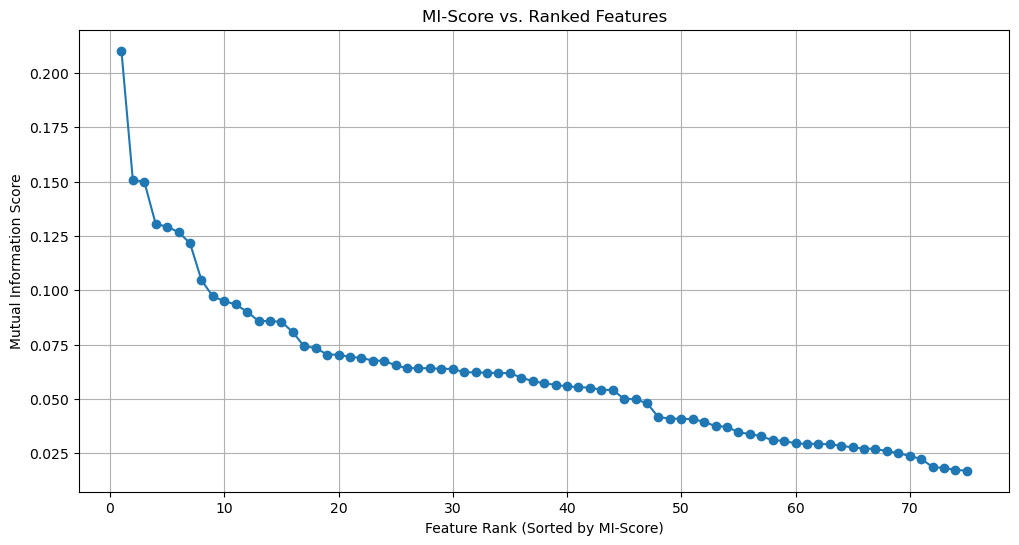

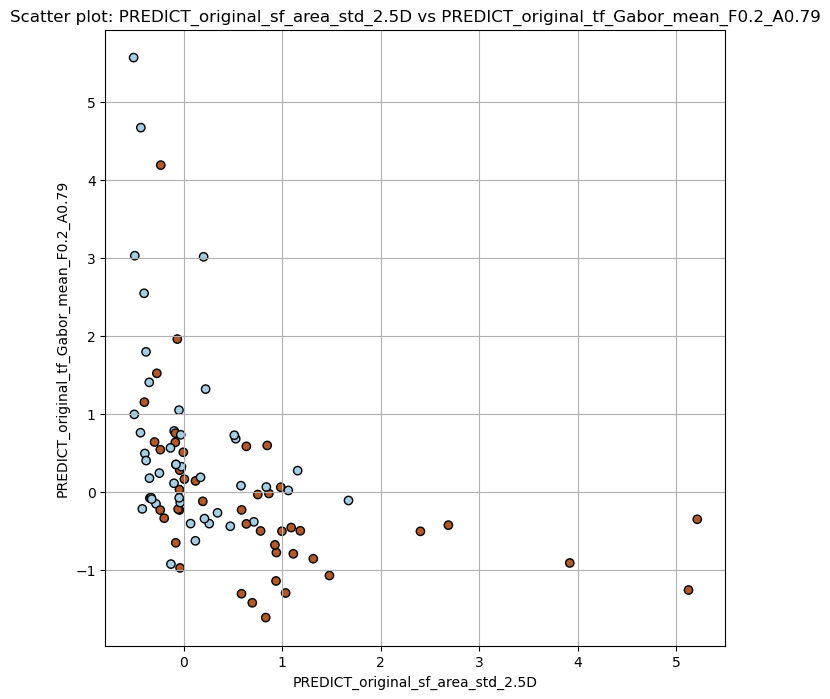

[Mutual Information] Selected top-75 features.


In [109]:
def select_features_mi(X_train, y_train, X_test, k=75, plot=True, random_state=42):
    """
    Selects the top-k features using mutual information (for non-linear dependencies).

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series or np.array): Training labels, numerically encoded
        X_test (pd.DataFrame): Test features.
        k (int): Number of top features to select.
        plot (bool): If True, plots MI scores and a 2D scatterplot of top 2 features.
        random_state (int): Random seed for reproducibility.

    Returns:
        X_train_mi (pd.DataFrame): Training set with selected features.
        X_test_mi (pd.DataFrame): Test set with selected features.
        selected_features (List[str]): Names of the selected features.
    """
    selector_mi = SelectKBest(lambda X, y: mutual_info_classif(X, y, random_state=random_state), k=k)
    X_train_filtered_mi_np = selector_mi.fit_transform(X_train, y_train)
    selected_features = X_train.columns[selector_mi.get_support()]

    X_train_mi = pd.DataFrame(X_train_filtered_mi_np, columns=selected_features, index=X_train.index)
    X_test_mi = pd.DataFrame(selector_mi.transform(X_test), columns=selected_features, index=X_test.index)

    print(f"[Mutual Information] Selected top-{k} features.")
    return X_train_mi, X_test_mi, selected_features

#X_filtered_train_mi_new, X_filtered_test_mi_new, mi_selected_features_new = select_features_mi(X_filtered_train_variance_new, y_train_numeric, X_filtered_test_variance_new)

Take union of ANOVA & MI selected sets: in this way we take linear and non-linear relations in the data

In [110]:
def combine_feature_sets_union(X_full_train, X_full_test, features1, features2):
    """
    Creates a feature subset based on the union of two feature lists.

    Args:
        X_full_train (pd.DataFrame): Original training DataFrame (after variance filtering).
        X_full_test (pd.DataFrame): Original test DataFrame (after variance filtering).
        features1 (List[str]): List of selected features (e.g., from ANOVA).
        features2 (List[str]): List of selected features (e.g., from MI).

    Returns:
        X_union_train (pd.DataFrame): Training set with union of features.
        X_union_test (pd.DataFrame): Test set with union of features.
        union_features (List[str]): Combined list of feature names.
    """
    union_features = list(set(features1).union(set(features2)))
    X_union_train = X_full_train[union_features]
    X_union_test = X_full_test[union_features]

    print(f"[Feature Union] Combined feature set size: {len(union_features)}")
    return X_union_train, X_union_test, union_features

#X_filtered_train_union_new, X_filtered_test_union_new, union_features_new = combine_feature_sets_union(X_filtered_train_variance_new, X_filtered_test_variance_new, anova_selected_features_new, mi_selected_features_new)
print(len(union_features_new))
print(union_features_new)

[Feature Union] Combined feature set size: 111
111
['PREDICT_original_tf_Gabor_quartile_range_F0.2_A0.79', 'PREDICT_original_phasef_monogenic_min_WL3_N5', 'PREDICT_original_tf_Gabor_energy_F0.5_A2.36', 'PREDICT_original_phasef_phasesym_kurtosis_WL3_N5', 'PREDICT_original_tf_Gabor_max_F0.05_A0.79', 'PREDICT_original_vf_Frangi_edge_std_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_tf_Gabor_std_F0.5_A1.57', 'PREDICT_original_tf_GLCMMS_contrastd3.0A2.36mean', 'PREDICT_original_sf_area_min_2.5D', 'PREDICT_original_vf_Frangi_full_skewness_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_tf_Gabor_std_F0.05_A0.0', 'PREDICT_original_logf_peak_position_sigma1', 'PREDICT_original_tf_Gabor_min_F0.5_A0.0', 'PREDICT_original_tf_LBP_energy_R8_P24', 'PREDICT_original_tf_Gabor_kurtosis_F0.5_A0.0', 'PREDICT_original_vf_Frangi_edge_kurtosis_SR(1.0, 10.0)_SS2.0', 'PREDICT_original_tf_Gabor_max_F0.2_A0.79', 'PREDICT_original_tf_Gabor_min_F0.05_A0.79', 'PREDICT_original_tf_LBP_quartile_range_R3_P12', 'PREDICT_original_tf_

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Bijvoorbeeld op een paar features uit union:
for feature in union_features_new[:70]:  # check bijv. eerste 5 features
    # sns.histplot(X_filtered_train_union_new[feature], kde=True)
    # plt.title(f'Distribution of {feature}')
    # plt.show()

    stat, p = stats.shapiro(X_filtered_train_union_new[feature])
    print(f"{feature}: p={p} (Shapiro-Wilk Test)")
    if p > 0.05:
        print(f"Feature {feature} follows a normal distribution")


Feature PREDICT_original_logf_peak_position_sigma1 follows a normal distribution


Testing n_features_to_select = 80


c:\Users\lloyd\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for 80 features: 0.9565
Testing n_features_to_select = 85


c:\Users\lloyd\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for 85 features: 0.9565
Testing n_features_to_select = 90


c:\Users\lloyd\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for 90 features: 0.9783
Testing n_features_to_select = 95


c:\Users\lloyd\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for 95 features: 0.9565


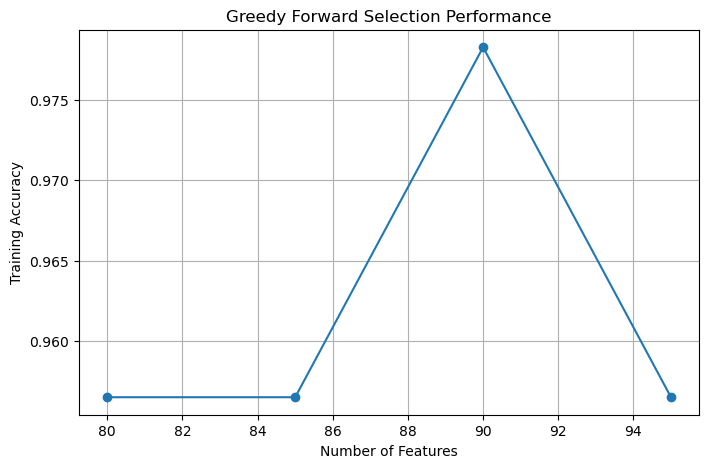


 Greedy Forward Selection complete.
Optimal number of features: 90
Best training accuracy: 0.9783


In [124]:
def greedy_forward_selection(
    X_train: pd.DataFrame,
    y_train: Union[pd.Series, list, np.ndarray],
    X_test: pd.DataFrame,
    model=None,
    feature_range: List[int] = None,
    scoring: str = 'accuracy',
    cv_splits: int = 5,
    plot: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame, List[str], int, float]:
    """
    Applies greedy forward feature selection with a given model.

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (array-like): Training labels.
        X_test (pd.DataFrame): Test features.
        model: Scikit-learn classifier (default: LogisticRegression).
        feature_range (list): List of n_features_to_select to evaluate.
        scoring (str): Scoring metric (e.g. 'accuracy', 'roc_auc').
        cv_splits (int): Number of folds for cross-validation.
        plot (bool): Whether to plot accuracy vs. feature count.

    Returns:
        X_train_selected (pd.DataFrame): Selected training features.
        X_test_selected (pd.DataFrame): Selected test features.
        best_features (List[str]): Names of selected features.
        best_n_features (int): Number of selected features.
        best_accuracy (float): Training accuracy using selected features.
    """
    if model is None:
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(max_iter=1000, random_state=42)

    if feature_range is None:
        total_features = X_train.shape[1]
        minimum_number_to_select = 10
        maximum_number_to_select = len(total_features)
        stepsize = 5
        feature_range = list(range(minimum_number_to_select, maximum_number_to_select+1, stepsize))

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    best_accuracy = 0
    best_n_features = None
    best_features = []
    accuracy_list = []

    for n_features in feature_range:
        print(f"Testing n_features_to_select = {n_features}")

        sfs = SequentialFeatureSelector(
            model,
            n_features_to_select=n_features,
            direction='forward',
            scoring=scoring,
            cv=cv,
            n_jobs=-1
        )
        sfs.fit(X_train, y_train)
        selected = list(X_train.columns[sfs.get_support()])

        X_train_sel = X_train[selected]
        X_test_sel = X_test[selected]

        # new model per run
        current_model = clone(model)
        current_model.fit(X_train_sel, y_train)
        acc = current_model.score(X_train_sel, y_train)
        accuracy_list.append(acc)

        print(f"Accuracy for {n_features} features: {acc:.4f}")

        if acc > best_accuracy:
            best_accuracy = acc
            best_n_features = n_features
            best_features = selected

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(feature_range, accuracy_list, marker='o')
        plt.xlabel("Number of Features")
        plt.ylabel(f"Training {scoring.capitalize()}")
        plt.title("Greedy Forward Selection Performance")
        plt.grid(True)
        plt.show()

    print("\n Greedy Forward Selection complete.")
    print(f"Optimal number of features: {best_n_features}")
    print(f"Best training {scoring}: {best_accuracy:.4f}")

    X_train_best = X_train[best_features]
    X_test_best = X_test[best_features]

    return X_train_best, X_test_best, best_features, best_n_features, best_accuracy

# Feature selection for the Logistic Regression Classifier
# Base estimator = Linear Regression
# Optimize number of features between 10 and the number of features in the union
X_train_selected_sfs_logistic, X_test_selected_sfs_logistic, sfs_selected_features_logistic, number_of_sfs_selected_features_logistic, train_acc_logistic = greedy_forward_selection(
    X_filtered_train_union_new, y_train_numeric, X_filtered_test_union_new,
    model=LogisticRegression(max_iter=1000, random_state=42),
    feature_range=list(range(80, 100, 5)),
    scoring='accuracy'
)

Testing n_features_to_select = 1
Accuracy for 1 features: 0.6739
Testing n_features_to_select = 2
Accuracy for 2 features: 0.7174
Testing n_features_to_select = 3
Accuracy for 3 features: 0.7283
Testing n_features_to_select = 4
Accuracy for 4 features: 0.7391
Testing n_features_to_select = 5
Accuracy for 5 features: 0.7609
Testing n_features_to_select = 6
Accuracy for 6 features: 0.7609
Testing n_features_to_select = 7
Accuracy for 7 features: 0.7609
Testing n_features_to_select = 8
Accuracy for 8 features: 0.7609
Testing n_features_to_select = 9
Accuracy for 9 features: 0.7609
Testing n_features_to_select = 10
Accuracy for 10 features: 0.7609
Testing n_features_to_select = 11
Accuracy for 11 features: 0.7609
Testing n_features_to_select = 12
Accuracy for 12 features: 0.7717
Testing n_features_to_select = 13
Accuracy for 13 features: 0.7826
Testing n_features_to_select = 14
Accuracy for 14 features: 0.7935
Testing n_features_to_select = 15
Accuracy for 15 features: 0.7935
Testing n_fea

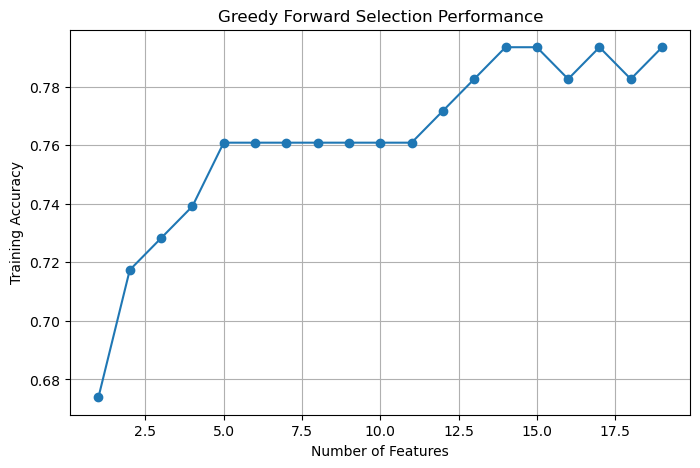


 Greedy Forward Selection complete.
Optimal number of features: 14
Best training accuracy: 0.7935


In [123]:
# Feature selection for the SVM classifier
# Base estimator = Linear Regression
# Optimize number of features with a max of 10
X_train_selected_sfs_logistic_max10, X_test_selected_sfs_logistic_max10, sfs_selected_features_logistic_max10, number_of_sfs_selected_features_logistic_max10, train_acc_logistic_max10 = greedy_forward_selection(
    X_filtered_train_union_new, y_train_numeric, X_filtered_test_union_new,
    model=LogisticRegression(max_iter=1000, random_state=42),
    feature_range=list(range(1, 20, 1)),
    scoring='accuracy'
)

In [ ]:
# First optimize k with grid search before using kNN as base esimator 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Train tijdelijk op alle union features
X_temp = X_filtered_train_union_new

# parameter grid
param_grid = {'n_neighbors': list(range(1, 21))}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_temp, y_train_numeric)

# Get best k 
best_k = grid_search.best_params_['n_neighbors']
print(f"Best k found by grid search: {best_k}")
print(f"Cross-validated accuracy: {grid_search.best_score_:.4f}")

# Gebruik best_k als base estimator
knn_best = KNeighborsClassifier(n_neighbors=best_k)

Best k found by grid search: 5
Cross-validated accuracy: 0.5754


✅ Best k found by grid search: 5
🔍 Cross-validated accuracy: 0.5754
Testing n_features_to_select = 1
Accuracy for 1 features: 0.7717
Testing n_features_to_select = 2
Accuracy for 2 features: 0.7717
Testing n_features_to_select = 3
Accuracy for 3 features: 0.7717
Testing n_features_to_select = 4
Accuracy for 4 features: 0.7935
Testing n_features_to_select = 5
Accuracy for 5 features: 0.7717
Testing n_features_to_select = 6
Accuracy for 6 features: 0.7717
Testing n_features_to_select = 7
Accuracy for 7 features: 0.8587
Testing n_features_to_select = 8
Accuracy for 8 features: 0.8261
Testing n_features_to_select = 9
Accuracy for 9 features: 0.8587
Testing n_features_to_select = 10
Accuracy for 10 features: 0.8370
Testing n_features_to_select = 11
Accuracy for 11 features: 0.8152
Testing n_features_to_select = 12
Accuracy for 12 features: 0.8478
Testing n_features_to_select = 13
Accuracy for 13 features: 0.8478
Testing n_features_to_select = 14
Accuracy for 14 features: 0.8261
Testing n_fe

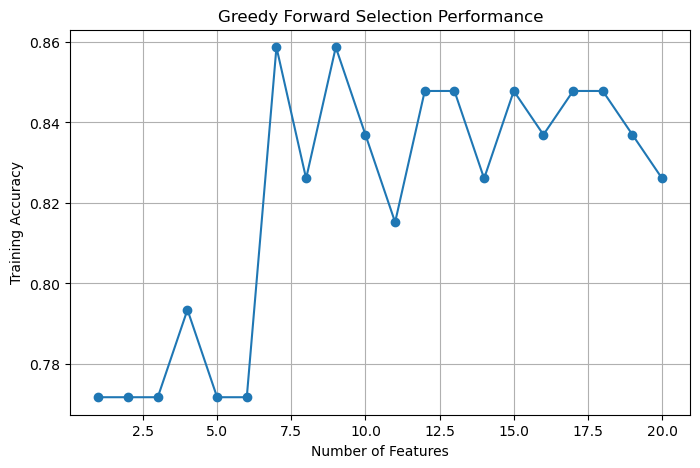


 Greedy Forward Selection complete.
Optimal number of features: 7
Best training accuracy: 0.8587


In [ ]:
# Feature selection for the kNN classifier
# Base estimator = kNN classifier
# Optimize number of features between 1 and the number of features in the union
X_train_selected_sfs_knn, X_test_selected_sfs_knn, sfs_selected_features_knn, number_of_sfs_selected_features_knn, train_acc_knn = greedy_forward_selection(
    X_filtered_train_union_new, y_train_numeric, X_filtered_test_union_new,
    model=knn_best,
    feature_range=list(range(1, 21, 1)),
    scoring='accuracy'
)

In [ ]:
print(sfs_selected_features_knn)

['PREDICT_original_logf_peak_position_sigma1', 'PREDICT_original_tf_LBP_peak_R3_P12', 'PREDICT_original_sf_area_std_2.5D', 'PREDICT_original_tf_LBP_peak_position_R3_P12', 'PREDICT_original_phasef_monogenic_mean_WL3_N5', 'PREDICT_original_tf_GLCMMS_contrastd1.0A0.79mean', 'PREDICT_original_tf_GLCMMS_dissimilarityd3.0A0.0std']


Further refining with rfecv

In [ ]:
def rfecv_refinement(
    X_train: pd.DataFrame,
    y_train: Union[pd.Series, list, np.ndarray],
    X_test: pd.DataFrame,
    model=None,
    min_features_to_select: int = 10,
    step: int = 1,
    scoring: str = 'accuracy',
    cv_splits: int = 4,
    plot: bool = True
):
    """
    Applies RFECV (recursive feature elimination with cross-validation) to refine a feature subset.

    Args:
        X_train (pd.DataFrame): Feature-selected training set.
        y_train (array-like): Labels.
        X_test (pd.DataFrame): Test set (same columns as X_train).
        model: Estimator to use (default: LogisticRegression).
        min_features_to_select (int): Minimum number of features to retain.
        step (int): How many features to remove at each iteration.
        scoring (str): Scoring metric.
        cv_splits (int): Number of CV folds.
        plot (bool): Whether to plot performance vs. feature count.

    Returns:
        X_train_refined (pd.DataFrame): Refined training set.
        X_test_refined (pd.DataFrame): Refined test set.
        selected_features (List[str]): Names of retained features.
        n_selected (int): Number of selected features.
        score (float): Final training score.
    """

    if model is None:
        model = LogisticRegression(max_iter=1000, random_state=42)

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    rfecv = RFECV(
        estimator=clone(model),
        step=step,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        min_features_to_select=min_features_to_select
    )

    print(f"\n Running RFECV refinement...")
    rfecv.fit(X_train, y_train)

    selected_features = X_train.columns[rfecv.get_support()]
    X_train_refined = X_train[selected_features]
    X_test_refined = X_test[selected_features]

    # Score model on refined set
    final_model = clone(model)
    final_model.fit(X_train_refined, y_train)
    score = final_model.score(X_train_refined, y_train)

    if plot and hasattr(rfecv, 'grid_scores_'):
        plt.figure(figsize=(8, 5))
        plt.plot(range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
                 rfecv.grid_scores_, marker='o')
        plt.xlabel("Number of Features")
        plt.ylabel(f"Cross-validated {scoring.capitalize()}")
        plt.title("RFECV Performance vs. Number of Features")
        plt.grid(True)
        plt.show()

    print(f"\n✅ RFECV selected {len(selected_features)} features")
    print("Top features:", list(selected_features))
    print(f"{scoring.capitalize()} on training set after refinement: {score:.4f}")

    return X_train_refined, X_test_refined, list(selected_features), len(selected_features), score

#X_train_refined_rfecv, X_test_refined_rfecv, refined_features, n_rfecv, train_score = rfecv_refinement(
    #X_train_selected_sfs, y_train_numeric, X_test_selected_sfs,
#)

Datasets after feature extraction

In [ ]:
#X_train_selected_final = X_train_selected_sfs
#print(X_train_selected_final.shape)
#X_test_selected_final = X_test_selected_sfs
#print(X_test_selected_final.shape)
#selected_features_final = sfs_selected_features
#print(len(selected_features_final))

Standardized scaling for Lasso Feature Selection

In [ ]:

def scaler_standardized(X_train, X_test):
    """
    Scales the original training and test datasets using standardization (zero mean, unit variance). 
    
    This function applies `StandardScaler` from `sklearn.preprocessing` to transform 
    `X_train` and `X_test`, which is necessary for Lasso feature selection and other 
    machine learning models that require standardized input.

    Returns:
        tuple: A tuple containing:
            - `X_scaled_standard_train` (pd.DataFrame): The standardized training dataset.
            - `X_scaled_standard_test` (pd.DataFrame): The standardized test dataset.
    
    Note:
        The function assumes `X_train` and `X_test` are already defined globally.
    """
    scaler_standard = preprocessing.StandardScaler()

    scaled_standard_array_train = scaler_standard.fit_transform(X_train)
    scaled_standard_array_test = scaler_standard.transform(X_test)

    X_scaled_standard_train = pd.DataFrame(scaled_standard_array_train, columns=X_train.columns)
    X_scaled_standard_test = pd.DataFrame(scaled_standard_array_test, columns=X_test.columns)

    return X_scaled_standard_train, X_scaled_standard_test


Encode the categorical y-labels to numerical values

In [ ]:
def y_numeric(y_train, y_test):
    """
    Encodes categorical labels from `y_train` and `y_test` into numeric values using `LabelEncoder`.

    This function applies `LabelEncoder` from `sklearn.preprocessing` to transform categorical target 
    labels into numerical format, which is essential for machine learning models that require numeric inputs.

    Args:
        y_train (pd.Series): The training labels.
        y_test (pd.Series): The test labels.

    Returns:
        tuple: A tuple containing:
            - `y_train_numeric` (numpy.ndarray): The transformed numeric labels for the training set.
            - `y_test_numeric` (numpy.ndarray): The transformed numeric labels for the test set.

    Prints:
        - A dictionary mapping numeric labels to their corresponding original class names.

    Note:
        The function assumes `y_train` and `y_test` contain categorical labels.
    """
    le = LabelEncoder()
    y_train_numeric = le.fit_transform(y_train)
    y_test_numeric = le.transform(y_test)

    # Store the mapping of labels
    legend_labels = le.classes_  # This saves the original class names
    print("Label Mapping:", {i: label for i, label in enumerate(legend_labels)})

    return y_train_numeric, y_test_numeric


Optimization based feature selection: LASSO

In [ ]:
#X_scaled_standard_train, X_scaled_standard_test = scaler_standardized (X_train, X_test)

def lasso_fs(X_scaled_standard_train, X_scaled_standard_test, y_train_numeric):
    """
    Performs optimization based feature selection using Lasso regression.

    This function applies Lasso regression with automatic hyperparameter tuning 
    (via `LassoCV`) to identify the most important features from the standardized training data.
    It selects features by penalizing less important coefficients, setting some to zero.
    
    Args:
        X_scaled_standard_train (pd.DataFrame): 
            The standardized training dataset with numerical features.

    Returns:
        tuple: A tuple containing:
            - `X_train_selected` (np.ndarray): The reduced training dataset containing only selected features.
            - `X_test_selected` (np.ndarray): The reduced test dataset containing only selected features.
    
    Prints:
        - The best `alpha` value found through cross-validation.
        - The names of the selected features.

    Note:
        - This function assumes `y_train_numeric` is globally defined.
        - `SelectFromModel` is used to remove unimportant features based on the Lasso model.
    """
    # Define LassoCV with cross-validation
    n_alphas = 200
    alphas = np.logspace(-10, -1, n_alphas)# Testing alpha from 0.0001 to 10
    random_state = 42 #  Using int will produce the same results everytime, 42 is along 0 the most popular choice
    lasso_cv = LassoCV(cv=5, alphas=alphas, random_state=random_state, max_iter=10000)  # TODO: cv = 5 chosen, what do we want?

    # Fit LassoCV on training data
    lasso_cv.fit(X_scaled_standard_train, y_train_numeric)

    # Get the best alpha value
    best_alpha = lasso_cv.alpha_

    # Train final Lasso model with optimal alpha
    lasso = Lasso(alpha=best_alpha, fit_intercept=False)
    lasso.fit(X_scaled_standard_train, y_train_numeric)

    # Select features
    selector = SelectFromModel(lasso, prefit=True)
    X_train_selected = selector.transform(X_scaled_standard_train)
    X_test_selected = selector.transform(X_scaled_standard_test)

    # Get selected feature indices and names
    selected_features = np.where(selector.get_support())[0]
    selected_feature_names = X_scaled_standard_train.columns[selected_features]
    n_features = len(selected_features)
    
    return best_alpha, X_train_selected, X_test_selected, selected_feature_names, n_features

# Capture the return values when calling the function
#best_alpha, X_train_sel_lasso, X_test_sel_lasso, selected_feature_names, n_features = lasso_fs(X_scaled_standard_train, X_scaled_standard_test, y_train_numeric)
#X_scaled_standard_train, X_scaled_standard_test = scaler_standardized(X_train, X_test)
#y_train_numeric, y_test_numeric = y_numeric(y_train, y_test)
# Print the captured values in the global scope
#print(f"Best alpha found: {best_alpha}")
#print("Selected Features:", selected_feature_names)
#print(f"N features found: {n_features}")



PCA feature extraction

In [ ]:
#X_scaled_standard_train, X_scaled_standard_test = scaler_standardized (X_train, X_test)
#best_alpha, X_train_sel, X_test_sel, selected_feature_names, n_features = lasso_fs(X_scaled_standard_train, X_scaled_standard_test, y_train_numeric)

def PCA_fs(X_scaled_standard_train, X_scaled_standard_test, target_variance=0.95):
    """
    Performs Principal Component Analysis (PCA) for feature reduction.

    This function applies PCA to reduce the dimensionality of the input data, 
    transforming the training and test datasets to a lower number of features 
    (specified by `n_features`), while retaining as much variance as possible.

    Args:
        n_features (int): 
            The number of principal components to retain after performing PCA.
            Based on the number of features of Lasso.

    Returns:
        tuple: A tuple containing:
            - `X_scaled_standard_train_PCA` (np.ndarray): The transformed training dataset with reduced features.
            - `X_scaled_standard_test_PCA` (np.ndarray): The transformed test dataset with reduced features.

    Notes:
        - The function assumes `X_scaled_robust_train` and `X_scaled_robust_test` are predefined globally.
        - The function applies the same transformation to both the training and test datasets, 
          ensuring that the test set is projected into the same lower-dimensional space as the training set.
    """
    pca = PCA(n_components=target_variance) # TODO: explain why 95% variance should be retained
    X_train_PCA = pca.fit_transform(X_scaled_standard_train)
    X_test_PCA = pca.transform(X_scaled_standard_test)  # Use the same transformation

    # Determine how many components were selected
    n_components_selected = pca.n_components_

    print(f"Selected {n_components_selected} components to retain {target_variance*100}% variance.")
    
    return pca, X_train_PCA, X_test_PCA, n_components_selected

# Assuming you already have the transformed PCA data
#pca, X_train_pca, X_test_pca, n_components_selected = PCA_fs(X_scaled_standard_train, X_scaled_standard_test, target_variance=0.95)
#best_alpha, X_train_sel, X_test_sel, selected_feature_names, n_features = lasso_fs(X_scaled_standard_train, X_scaled_standard_test, y_train_numeric)

# Plot the cumulative variance versus the number of components
#plt.figure(figsize=(8,5))
#plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
#plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance")
#plt.axvline(x=n_components_selected, color='g', linestyle='--', label=f"{n_components_selected} Components")
#plt.xlabel('Number of Principal Components')
#plt.ylabel('Cumulative Explained Variance')
#plt.title('Explained Variance vs. Number of Components')
#plt.legend()
#plt.grid()
#plt.show()

Testing feature selections 

In [ ]:
# # Zet de labels om naar numerieke waarden
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)  # Zet 'lipoma' en 'liposarcoma' om naar 0 en 1
# y_test = le.transform(y_test)  # Pas dezelfde transformatie toe op y_test

def test_lasso(X_train_sel_lasso, X_test_sel_lasso, y_test_numeric):

    # Define the classifiers
    classifiers = {
        "LogisticRegression": LogisticRegression(max_iter=500, random_state=42),
        "LDA": LinearDiscriminantAnalysis(),
        "QDA": QuadraticDiscriminantAnalysis(),
        "kNN": KNeighborsClassifier(n_neighbors=5)  # Je kunt het aantal neighbors aanpassen
    }

    # cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Store fitted classifiers
    clfs_fit = []

    # Select the same features for the test set
    X_train_selected = X_train_sel_lasso
    X_test_selected = X_test_sel_lasso
    print(X_test_selected.shape)
    print(y_test_numeric.shape)

    # Train and evaluate classifiers
    for clf_name, clf in classifiers.items():
        # Train classifier
        # clf.fit(X_train_selected, y_train_numeric)
        Y_pred = cross_val_predict(clf, X_train_selected, y_train_numeric, cv=cv)

        # Store fitted classifier
        clfs_fit.append(copy.deepcopy(clf))

        # Compute evaluation metrics
        accuracy = metrics.accuracy_score(y_train_numeric, Y_pred)

        # Handle the case where we can get probabilities
        if hasattr(clf, 'predict_proba'):
            # Get the probability for class 1 (index 1)
            y_score = cross_val_predict(clf, X_train_selected, y_train_numeric, cv=cv, method='predict_proba')[:, 1]
        else:
            # If predict_proba is not available, use the binary predictions
            y_score = Y_pred  # Use binary predictions if probability is unavailable

        auc = metrics.roc_auc_score(y_train_numeric, y_score)
        f1 = metrics.f1_score(y_train_numeric, Y_pred)
        precision = metrics.precision_score(y_train_numeric, Y_pred)
        recall = metrics.recall_score(y_train_numeric, Y_pred)

        # Print the results
        print(f"Classifier: {clf.__class__.__name__}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  AUC: {auc:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print("-" * 50)

#test_lasso(X_train_sel_lasso, X_test_sel_lasso, y_test_numeric)

In [ ]:
# # Zet de labels om naar numerieke waarden
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)  # Zet 'lipoma' en 'liposarcoma' om naar 0 en 1
# y_test = le.transform(y_test)  # Pas dezelfde transformatie toe op y_test

def test_pca(X_train_pca, X_test_pca, y_train_numeric):

    # Define the classifiers
    classifiers = {
        "LogisticRegression": LogisticRegression(max_iter=500, random_state=42),
        "LDA": LinearDiscriminantAnalysis(),
        "QDA": QuadraticDiscriminantAnalysis(),
        "kNN": KNeighborsClassifier(n_neighbors=5)  # Je kunt het aantal neighbors aanpassen
    }

    # cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Store fitted classifiers
    clfs_fit = []

    # Select the same features for the test set
    X_train_selected_pca = X_train_pca
    X_test_selected_pca = X_test_pca
    print(X_test_selected_pca.shape)

    # Train and evaluate classifiers
    for clf_name, clf in classifiers.items():
        # Train classifier
        # clf.fit(X_train_selected, y_train_numeric)
        Y_pred = cross_val_predict(clf, X_train_selected_pca, y_train_numeric, cv=cv)

        # Store fitted classifier
        clfs_fit.append(copy.deepcopy(clf))

        # Compute evaluation metrics
        accuracy = metrics.accuracy_score(y_train_numeric, Y_pred)

        # Handle the case where we can get probabilities
        if hasattr(clf, 'predict_proba'):
            # Get the probability for class 1 (index 1)
            y_score = cross_val_predict(clf, X_train_selected_pca, y_train_numeric, cv=cv, method='predict_proba')[:, 1]
        else:
            # If predict_proba is not available, use the binary predictions
            y_score = Y_pred  # Use binary predictions if probability is unavailable

        auc = metrics.roc_auc_score(y_train_numeric, y_score)
        f1 = metrics.f1_score(y_train_numeric, Y_pred)
        precision = metrics.precision_score(y_train_numeric, Y_pred)
        recall = metrics.recall_score(y_train_numeric, Y_pred)

        # Print the results
        print(f"Classifier: {clf.__class__.__name__}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  AUC: {auc:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print("-" * 50)

#test_pca(X_train_pca, X_test_pca, y_train_numeric)

## Model selection
Random forest, decision tree and bagging

In [ ]:
def forest_tree_classifiers(y_train, X_train):

    # Encode categorical labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    # Define models and parameter distributions
    models = {
        "Random Forest": (RandomForestClassifier(random_state=42), {
            'n_estimators': randint(5, 200),
            'max_depth': randint(3, 20),
            'min_samples_split': randint(5, 20),
            'bootstrap': [True, False]
        }),
        "Bagging": (BaggingClassifier(DecisionTreeClassifier(random_state=42), random_state=42), {
            'n_estimators': randint(5, 200),
            'estimator__max_depth': randint(3, 5),
            'estimator__min_samples_split': randint(5, 20),
            'bootstrap': [True, False]
        }),
        "Decision Tree": (DecisionTreeClassifier(random_state=42), {
            'max_depth': randint(3, 5),
            'min_samples_split': randint(5, 20)
        })
    }

    # Perform Randomized Search and store results
    best_estimators = {}
    best_params = {}
    best_scores = {}

    for name, (model, param_dist) in models.items():
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=30,
            scoring='accuracy',
            cv=10,
            n_jobs=-1,
            random_state=42
        )
        search.fit(X_train, y_train_encoded) # Fitted on data without scaling and feature selection

        best_estimators[name] = search.best_estimator_
        best_params[name] = search.best_params_
        best_scores[name] = search.best_score_

    # Print results
    print("\n=== Model Comparison ===")
    for model_name in models.keys():
        print(f"\nBest {model_name}: {best_estimators[model_name]}")
        print(f"Best {model_name} Parameters: {best_params[model_name]}")
        print(f"Best {model_name} Accuracy: {best_scores[model_name]:.4f}")

    return best_estimators, y_train_encoded, best_scores

#best_estimators, y_train_encoded, best_scores = forest_tree_classifiers(y_train, X_train)

SVM

In [ ]:
def svm_classifier(X_train_selected_final, y_train_encoded):

    # Define base SVM model
    svm_model = SVC(probability=True, random_state=42)

    # Define parameter distribution for RandomizedSearchCV
    param_dist = {
        'C': [0.1, 1, 10, 100, 1000],  # Regularization parameter
        'gamma': ['scale', 'auto', 0.1, 1, 10, 100],  # Kernel coefficient
        'kernel': ['linear', 'rbf', 'poly'],  # Different kernel types
        'degree': [1, 2, 3, 4, 5, 6],  # Only used for poly kernel
    }

    # Randomized Search with cv=10
    random_search = RandomizedSearchCV(
        estimator=svm_model,
        param_distributions=param_dist,
        n_iter=30,  # More iterations for better results
        scoring='accuracy',
        cv=10,  # 10-fold cross-validation
        n_jobs=-1,  # Use all CPU cores
        random_state=42
    )

    # Fit on robustly scaled training data
    random_search.fit(X_train_selected_final, y_train_encoded)

    # Get the best model and parameters
    best_svm = random_search.best_estimator_
    best_params_svm = random_search.best_params_
    best_score_svm = random_search.best_score_

    # Print results
    print("\n=== Best SVM Model After Randomized Search ===")
    print(f"Best SVM: {best_svm}")
    print(f"Best SVM Parameters: {best_params_svm}")
    print(f"Best SVM Accuracy: {best_score_svm:.4f}")

    return best_svm, best_score_svm

#best_svm, best_score_svm = svm_classifier(X_train_selected_final, y_train_encoded)

kNN

In [ ]:
def knn_classifier(X_train_selected_final, y_train_encoded):

    # Define base kNN model
    knn_model = KNeighborsClassifier()

    # Define parameter distribution for RandomizedSearchCV
    param_dist_knn = {
        'n_neighbors': randint(3, 50),
        'weights': ['uniform', 'distance'],
        'p': [1, 2],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': randint(20, 60),
        'metric': ['minkowski', 'euclidean', 'manhattan']
    }

    cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    random_search_knn = RandomizedSearchCV(
        estimator=knn_model,
        param_distributions=param_dist_knn,
        n_iter=30,
        scoring='accuracy',
        cv=cv_strategy,  
        n_jobs=-1,
        random_state=42
    )

    # Fit op geschaalde data
    random_search_knn.fit(X_train_selected_final, y_train_encoded)

    # Beste model, parameters, en score ophalen
    best_knn = random_search_knn.best_estimator_
    best_params_knn = random_search_knn.best_params_
    best_score_knn = random_search_knn.best_score_

    # Resultaten afdrukken
    print("\n=== Best kNN Model After Randomized Search ===")
    print(f"Best kNN: {best_knn}")
    print(f"Best kNN Parameters: {best_params_knn}")
    print(f"Best kNN Accuracy: {best_score_knn:.4f}")

    return best_knn, best_score_knn

#best_knn, best_score_knn = knn_classifier(X_train_selected_final, y_train_encoded)

Logistic regression

In [ ]:
def lr_classifier(X_train_selected_final, y_train_encoded):

    # Function to perform cross-validation and get accuracy
    def perform_cross_val(model, X, y, cv=10):
        return np.mean(cross_val_score(model, X, y, cv=cv, scoring='accuracy'))

    # Perform cross-validation for Logistic Regression with default parameters
    log_reg_model = LogisticRegression(max_iter=5000)
    log_reg_score = perform_cross_val(log_reg_model, X_train_selected_final, y_train_encoded)
    print(f"\nAccuracy for Logistic Regression: {log_reg_score:.4f}")

    return log_reg_score, log_reg_model

#log_reg_score, log_reg_model = lr_classifier(X_train_selected_final, y_train_encoded)

## Learning curves

In [ ]:
def learning_curves(best_estimators, X_train, y_train_encoded, best_knn, X_train_selected_final, log_reg_model):

    # Create subplots (2 rows, 2 columns)
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))

    # Plot learning curves for each best model
    #plot_learning_curve(best_svm, "SVM Learning Curve", X_train_selected_final, y_train_encoded, axes[0, 0], cv=10)
    plot_learning_curve(best_estimators["Random Forest"], "Random Forest Learning Curve", X_train, y_train_encoded, axes[0, 1], cv=10)
    plot_learning_curve(best_estimators["Bagging"], "Bagging Classifier Learning Curve", X_train, y_train_encoded, axes[1, 0], cv=10)
    plot_learning_curve(best_estimators["Decision Tree"], "Decision Tree Learning Curve", X_train, y_train_encoded, axes[1, 1], cv=10)
    plot_learning_curve(best_knn, "kNN Learning Curve", X_train_selected_final, y_train_encoded, axes[2, 0], cv=10)
    plot_learning_curve(log_reg_model, "Linear Regression Learning Curve", X_train_selected_final, y_train_encoded, axes[2, 1], cv=10)


    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

#learning_curves(best_estimators, X_train, y_train_encoded, best_knn, X_train_selected_final, log_reg_model)


## Evaluation

In [ ]:
def evaluation_classifiers(best_scores, best_score_knn, X_scaled_robust_train, X_scaled_robust_test, y_train_encoded, best_knn, X_train_selected_final, X_test_selected_final, y_test, y_train, log_reg_score):

    # Store model names and best accuracy scores
    model_scores = {
        "Random Forest": best_scores["Random Forest"],
        "Bagging": best_scores["Bagging"],
        "Decision Tree": best_scores["Decision Tree"],
        #"SVM": #best_score_svm,
        "kNN": best_score_knn,
        "Logistic Regression": log_reg_score
    }

    # Identify the best model
    best_model_name = max(model_scores, key=model_scores.get)
    print(f"\nBest Overall Model: {best_model_name}")

    # Determine the correct dataset and fit the best model
    if best_model_name in best_estimators:  # Models trained on X_scaled_robust_train
        best_model = best_estimators[best_model_name]
        best_model.fit(X_scaled_robust_train, y_train_encoded)
        y_score = best_model.predict_proba(X_scaled_robust_test)
        y_pred = best_model.predict(X_scaled_robust_test)
        
    elif best_model_name == "SVM":
        best_model = best_svm
        best_model.fit(X_train_selected_final, y_train_encoded)
        y_score = best_model.predict_proba(X_test_selected_final)  # Use same subset of features
        y_pred = best_model.predict(X_test_selected_final)

    elif best_model_name == "kNN":
        best_model = best_knn
        best_model.fit(X_train_selected_final, y_train_encoded)
        y_score = best_model.predict_proba(X_test_selected_final)
        y_pred = best_model.predict(X_test_selected_final)

    elif best_model_name == "Logistic Regression":
        best_model = LogisticRegression(max_iter=5000)
        best_model.fit(X_train_selected_final, y_train_encoded)
        y_score = best_model.predict_proba(X_test_selected_final)
        y_pred = best_model.predict(X_test_selected_final)

    # Print results
    print(f"\nFinal Model: {best_model_name}")
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred)

    # Print the accuracy and F1 score
    print(f"Accuracy on the Test Set: {accuracy:.4f}")
    print(f"F1 Score on the Test Set: {f1:.4f}")

    # Plot ROC curve
    fpr, tpr, auc_value = plot_roc_curve(y_score, y_test_encoded)

    return fpr, tpr, auc_value

#fpr, tpr, auc_value = evaluation_classifiers(best_scores, best_score_knn, X_scaled_robust_train, X_scaled_robust_test, y_train_encoded, best_knn, X_train_selected_final, X_test_selected_final, y_test, y_train, log_reg_score)


## Performance estimate

In [ ]:
cv_5fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_fpr = []
all_tpr = []
all_auc = []

# Loop over the folds
for validation_index, test_index in cv_5fold.split(X, y):
    # Split the data properly
    print('=' * 30 + 'START ONE FOLD' + '=' * 30)
    X_train = X.iloc[validation_index]
    y_train = y.iloc[validation_index]

    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    # Missing data
    total_missing = find_missing_data(X_train)
    X_train, X_test = process_missing_data(X_train, X_test, total_missing)

    # Scaling
    X_scaled_robust_train, X_scaled_robust_test = scaling(X_train, X_test)

    print('-' * 30 + 'Start feature selection' + '-' * 30)
    # Feature selection
    y_train_numeric, y_test_numeric = y_numeric(y_train, y_test)
    X_filtered_train_variance_new, X_filtered_test_variance_new, variance_filtered_features_new = apply_variance_threshold(X_scaled_robust_train, X_scaled_robust_test)
    X_filtered_train_anova_new, X_filtered_test_anova_new, anova_selected_features_new = select_features_anova(X_filtered_train_variance_new, y_train_numeric, X_filtered_test_variance_new)
    X_filtered_train_mi_new, X_filtered_test_mi_new, mi_selected_features_new = select_features_mi(X_filtered_train_variance_new, y_train_numeric, X_filtered_test_variance_new)
    X_filtered_train_union_new, X_filtered_test_union_new, union_features_new = combine_feature_sets_union(X_filtered_train_variance_new, X_filtered_test_variance_new, anova_selected_features_new, mi_selected_features_new)
    X_train_selected_sfs, X_test_selected_sfs, sfs_selected_features, number_of_sfs_selected_features, train_acc = greedy_forward_selection(
    X_filtered_train_union_new, y_train_numeric, X_filtered_test_union_new,
    feature_range=[90],
    scoring='accuracy'
    )
    # DIT NOG AANPASSEN
    X_train_selected_final = X_train_selected_sfs
    X_test_selected_final = X_test_selected_sfs
    selected_features_final = sfs_selected_features

    X_scaled_standard_train, X_scaled_standard_test = scaler_standardized (X_train, X_test)
    
    # Capture the return values when calling the function
    best_alpha, X_train_sel_lasso, X_test_sel_lasso, selected_feature_names, n_features = lasso_fs(X_scaled_standard_train, X_scaled_standard_test, y_train_numeric)
    best_alpha, X_train_sel, X_test_sel, selected_feature_names, n_features = lasso_fs(X_scaled_standard_train, X_scaled_standard_test, y_train_numeric)    
    X_scaled_standard_train, X_scaled_standard_test = scaler_standardized(X_train, X_test)
    # Print the captured values in the global scope
    print(f"Best alpha found: {best_alpha}")
    print("Selected Features:", selected_feature_names)
    print(f"N features found: {n_features}")

    pca, X_train_pca, X_test_pca, n_components_selected = PCA_fs(X_scaled_standard_train, X_scaled_standard_test, target_variance=0.95)
    test_lasso(X_train_sel_lasso, X_test_sel_lasso, y_test_numeric)
    test_pca(X_train_pca, X_test_pca, y_train_numeric)

    print('-' * 30 + 'Start training classifiers' + '-' * 30)
    # Classifiers
    best_estimators, y_train_encoded, best_scores = forest_tree_classifiers(y_train, X_train)
    #best_svm, best_score_svm = svm_classifier(X_train_selected_final, y_train_encoded)
    best_knn, best_score_knn = knn_classifier(X_train_selected_final, y_train_encoded)
    log_reg_score, log_reg_model = lr_classifier(X_train_selected_final, y_train_encoded)

    # Learning curves
    learning_curves(best_estimators, X_train, y_train_encoded, best_knn, X_train_selected_final, log_reg_model)

    # Evaluation
    fpr, tpr, auc_value = evaluation_classifiers(best_scores, best_score_knn, X_scaled_robust_train, X_scaled_robust_test, y_train_encoded, best_knn, X_train_selected_final, X_test_selected_final, y_test, y_train, log_reg_score)

    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(auc_value)

    print('=' * 30 + 'END ONE FOLD' + '=' * 30)

plt.figure(figsize=(10, 8))
for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], label=f'Fold {i+1} (AUC = {all_auc[i]:.2f})')
    
# Plot a diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for 5-fold Cross Validation')
plt.legend(loc='lower right')
plt.show()